In [1]:
import math
import numpy as np
from os.path import isfile, join
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, Input, AveragePooling2D
from keras.optimizers import adam_v2
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.applications.inception_v3 import InceptionV3
from keras.metrics import Precision, Recall

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
VALIDATION_SPLIT = 0.1
EPOCHS = 100

In [4]:
def build_inceptionV3(img_shape=(220, 220, 3), n_classes=9, l2_reg=0.,
                load_pretrained=True, freeze_layers_from='base_model'):
    # Decide if load pretrained weights from imagenet
    if load_pretrained:
        weights = 'imagenet'
    else:
        weights = None

    # Get base model
    base_model = InceptionV3(include_top=False, weights=weights,
                             input_tensor=None, input_shape=img_shape)

    # Add final layers
    x = base_model.output
    x = AveragePooling2D((5, 5), strides=(5, 5), name='avg_pool')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='swish', name='dense_1', kernel_initializer='he_uniform')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='swish', name='dense_2', kernel_initializer='he_uniform')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(n_classes, activation='softmax', name='predictions', kernel_initializer='he_uniform')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze some layers
    if freeze_layers_from is not None:
        if freeze_layers_from == 'base_model':
            print ('   Freezing base model layers')
            for layer in base_model.layers:
                layer.trainable = False
        else:
            for i, layer in enumerate(model.layers):
                print(i, layer.name)
            print ('   Freezing from layer 0 to ' + str(freeze_layers_from))
            for layer in model.layers[:freeze_layers_from]:
               layer.trainable = False
            for layer in model.layers[freeze_layers_from:]:
               layer.trainable = True

    adam = adam_v2.Adam(0.0001) 
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy',Precision(), Recall()])  
    # model.summary()
    return model 

In [5]:
import os
from sklearn.preprocessing import OneHotEncoder
typetoint = {'Cave-Arch':1,'Chola':2,'Hoysala':3,'Kalinga':4,'Kerala':5,'MaruGurjara':6,'Mughal':7,'Rajput':8,'Tibetan':9}
path = "/content/drive/MyDrive/ML-Lab/Data/Replicated+Filtered/LatestFilteredPics"
#loading the saved file once again
features = np.load(os.path.join(path,'features.npy'))
classes = np.load(os.path.join(path,'classnames.npy'))
new_ar = []
class_names = []
for i in range(len(features)):
  features[i] = np.squeeze(features[i], axis=0)
  #features[i] = features[i].reshape(1,220,220,3)
  new_ar.append(features[i].flatten())
  class_names.append(typetoint[classes[i]])
classesint = np.array(class_names)
classlist = []
for i in range(len(classesint)):
  lst = [0,0,0,0,0,0,0,0,0]
  lst[classesint[i]-1] = 1
  classlist.append(lst)
classesint = np.array(classlist)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, classesint, test_size=0.1, random_state=0)
X_train = np.squeeze(X_train, axis=1)
X_test = np.squeeze(X_test, axis=1)

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4988, 220, 220, 3) (4988, 9) (555, 220, 220, 3) (555, 9)


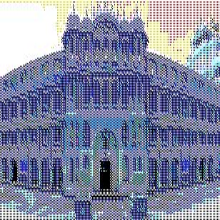

In [8]:
from PIL import Image
from google.colab.patches import cv2_imshow
cv2_imshow(X_test[1])

In [9]:
key_list = list(typetoint.keys())
val_list = list(typetoint.values())
key_list[val_list.index(y_test[6].tolist().index(1)+1)]

'Hoysala'

In [10]:
import tensorflow
csv_logger = tensorflow.keras.callbacks.CSVLogger('/content/drive/MyDrive/ML-Lab/EpochLogs/InceptionV3/Version7.csv')

In [11]:
model = build_inceptionV3()
BATCH_SIZE = 32
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs= EPOCHS, verbose= 1, validation_split=VALIDATION_SPLIT,
    #steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    callbacks = [csv_logger]
    )

87924736/87910968 [==============================] - 0s 0us/step
   Freezing base model layers
Epoch 1/100
141/141 [==============================] - 31s 105ms/step - loss: 13.8937 - accuracy: 0.1328 - precision: 0.1340 - recall: 0.1239 - val_loss: 3.2733 - val_accuracy: 0.1563 - val_precision: 0.1851 - val_recall: 0.1042
Epoch 2/100
141/141 [==============================] - 11s 78ms/step - loss: 4.6585 - accuracy: 0.1666 - precision: 0.1807 - recall: 0.1337 - val_loss: 2.5130 - val_accuracy: 0.2204 - val_precision: 0.2985 - val_recall: 0.0802
Epoch 3/100
141/141 [==============================] - 11s 79ms/step - loss: 3.1083 - accuracy: 0.1891 - precision: 0.2188 - recall: 0.1076 - val_loss: 2.2575 - val_accuracy: 0.2024 - val_precision: 0.1967 - val_recall: 0.0240
Epoch 4/100
141/141 [==============================] - 11s 79ms/step - loss: 2.3392 - accuracy: 0.1978 - precision: 0.2982 - recall: 0.0555 - val_loss: 2.0967 - val_accuracy: 0.2104 - val_precision: 0.5161 - val_recall: 0.

In [12]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 109, 109, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
# model.load_weights(savepath1 + 'wts/iv3/inception_v3-06-0.82.hdf5')
# model.load_weights(savepath1 + 'wts/iv3/inception_v3_512-04-0.78.hdf5')
#for 100 epochs
a= model.evaluate(X_test, y_test, verbose=1, batch_size= BATCH_SIZE)
print(a)

18/18 [==============================] - 2s 131ms/step - loss: 1.6775 - accuracy: 0.5982 - precision: 0.6509 - recall: 0.5441
[1.6774835586547852, 0.5981981754302979, 0.6508620977401733, 0.5441441535949707]
